In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [3]:

import torch
import RETFound_MAE.models_vit as models_vit
from RETFound_MAE.util.pos_embed import interpolate_pos_embed
from timm.models.layers import trunc_normal_

# call the model
model = models_vit.__dict__['vit_large_patch16'](
    num_classes=2,
    drop_path_rate=0.2,
    global_pool=True,
)

# load RETFound weights
checkpoint = torch.load('./RETFound_MAE/RETFound_cfp_weights.pth', map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# interpolate position embedding
interpolate_pos_embed(model, checkpoint_model)

# load pre-trained model
msg = model.load_state_dict(checkpoint_model, strict=False)

assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}

# manually initialize fc layer
trunc_normal_(model.head.weight, std=2e-5)

print("Model = %s" % str(model))

Model = VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Att

In [4]:
#swap out the last layer
model.head = torch.nn.Linear(in_features=1024, out_features=3, bias=True)


In [5]:
#load images in RETFound_dataset and transform them
import torch
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch Tensor data type
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])


In [6]:
#paths of datasets
base_path_rfmid = './RFMiD/Training_Set/'
base_path_rfmid2 = './RFMiD2_0/Training_set/'
base_path_odir5k = './ODIR-5K/Training Images/'
base_path_1000images = './1000images/'
base_path_icar = './RIPS/'
keywords = {'normal': ['normal', 'healthy'], 'armd' : ['ARMD', 'armd'], 'rp': ['RP', 'rp', 'Retinitis pigmenntosa', 'retinitis pigmentosa'] }
list_base_paths = [base_path_rfmid, base_path_rfmid2, base_path_odir5k, base_path_1000images, base_path_icar]


In [7]:
#clear retfound dataset folder and folder structure
import os, shutil
folder = './RETFound_dataset'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        shutil.rmtree(file_path)
    except OSError:
        os.remove(file_path)


In [8]:
rfmid_data_split = {'rp':'train', 'armd':'train', 'normal':'train'}
rfmid2_data_split = {'rp':'train', 'armd':'test', 'normal':'train'}
odir5k_data_split = {'rp':'train', 'armd':'test', 'normal':'test'}
images1000_data_split = {'rp':'test', 'normal':'train'}
icar_data_split = {'rp':'test'}
data_splits = [rfmid_data_split, rfmid2_data_split, odir5k_data_split, images1000_data_split, icar_data_split]

In [9]:
#create train and test folders if they don't exist
import os
split_paths = {'train': './RETFound_dataset/train', 'test': './RETFound_dataset/test', 'val': './RETFound_dataset/val'}
for split in split_paths.keys():
    if not os.path.exists(split_paths[split]):
        os.makedirs(split_paths[split])
    for label in keywords.keys():
        if not os.path.exists(split_paths[split] + '/' + label):
            os.makedirs(split_paths[split] + '/' + label)

In [10]:
#bring in the images
import os, shutil
for base_path, data_split in zip(list_base_paths, data_splits):
    for label in data_split.keys():
        for keyword_aliases in keywords[label]:
            #check if a folder exists for at least one of the aliases
            if os.path.exists(base_path + keyword_aliases):
                #copy images to the retfound dataset folder
                for filename in os.listdir(base_path + keyword_aliases):
                    file_path = os.path.join(base_path + keyword_aliases, filename)
                    shutil.copy(file_path, split_paths[data_split[label]] + '/' + label + '/' + filename)


In [11]:
#move all files that ever contain the word subject1 or subject4 from the test folder to the train folder
for filename in os.listdir('./RETFound_dataset/test/rp'):
    if 'subject1' in filename or 'subject4' in filename:
        file_path = os.path.join('./RETFound_dataset/test/rp', filename)
        shutil.move(file_path, './RETFound_dataset/train/rp/' + filename)

In [12]:

# Load images and apply transformations
train_set = datasets.ImageFolder('RETFound_dataset/train/', transform=transform)
test_set = datasets.ImageFolder('RETFound_dataset/test/', transform=transform)
# Create a DataLoader
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)


In [13]:
print(f"Number of training examples, test examples: {len(train_set)}, {len(test_set)}")

Number of training examples, test examples: 413, 1778


(161, 166, 86)


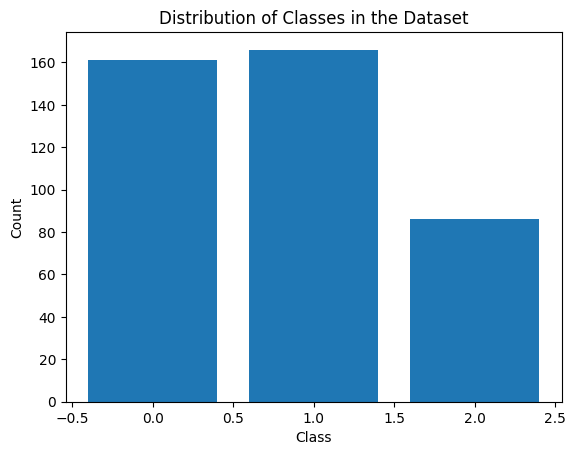

60
166
161


In [14]:
from collections import Counter
#print class distribution in train set
class_counts = Counter(train_set.targets)

# Extract class labels and their corresponding counts
classes, counts = zip(*class_counts.items())
print(counts)
# Plot the distribution of classes
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in the Dataset')
plt.show()
#print number of files in test/rp
print(len(os.listdir('./RETFound_dataset/test/rp')))
#print number of files in train/normal
print(len(os.listdir('./RETFound_dataset/train/normal')))
#print number of files in train/armd
print(len(os.listdir('./RETFound_dataset/train/armd')))

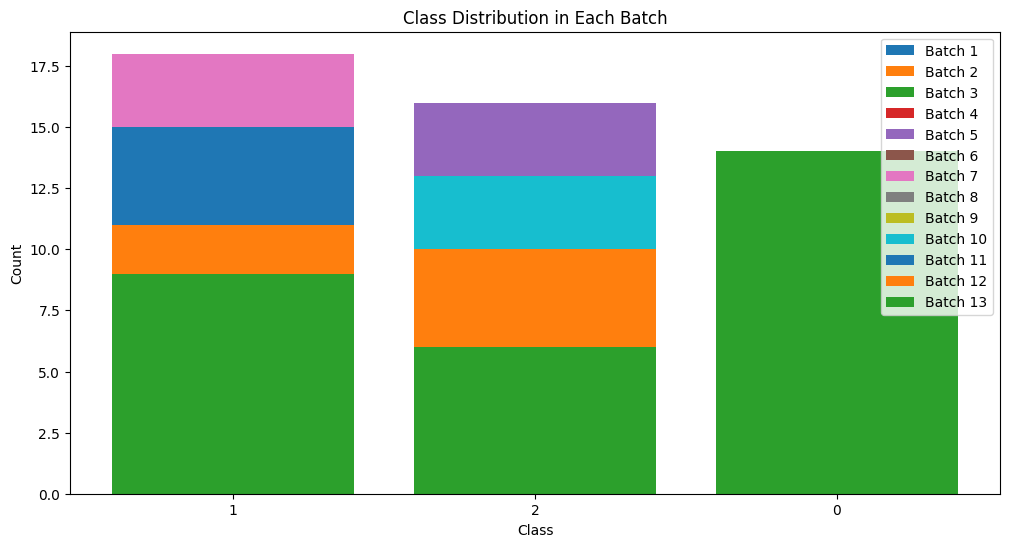

In [15]:
#visualize class distribution in train_dataloader batches
import matplotlib.pyplot as plt
from collections import Counter

# Initialize a list to store the counts for each batch
counts = []

# Iterate over the DataLoader
for _, labels in train_dataloader:
    # Count the number of instances for each class in the batch
    count = Counter(labels.numpy())
    # Append the counts to the list
    counts.append(count)

# Plot the counts
plt.figure(figsize=(12, 6))
for i, count in enumerate(counts):
    plt.bar(range(len(count)), list(count.values()), tick_label=list(count.keys()), label=f'Batch {i+1}')
plt.legend()
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Each Batch')
plt.show()


In [ ]:
#create an augmented train dataset
from torchvision import transforms
augmenting_transform = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation([90, 180, 270]),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
)

In [17]:
from tqdm import tqdm
import time

device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'You are training on:{device}')
#use cross entropy loss
criterion = torch.nn.CrossEntropyLoss()
#use adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1
#train the model
for epoch in range(epochs):
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}')
    for images, labels in progress_bar:
        #transfer to gpu
        images, labels = images.to(device), labels.to(device)
        #zero gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        #calculate loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update parameters
        optimizer.step()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total = labels.size(0)

        # Total correct predictions
        correct = (predicted == labels).sum().item()

        # Print accuracy
        progress_bar.set_postfix({'Loss': '{:.4f}'.format(loss.item()), 'Accuracy': '{:.2f}%'.format(100 * correct / total)})
#save model, change later to save best model
torch.save(model.state_dict(), f'RETFound_MAE/weights/{time.strftime("%Y%m%d_%H%M")}_RETFound_cfp_fine_tuned_ep1_weights.pth')


You are training on:cpu


Epoch 1/1: 100%|██████████| 51/51 [31:34<00:00, 37.14s/it, Loss=0.2021, Accuracy=95.00%] 


In [18]:
#evaluate model on test set with confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluation mode
model.eval()

# Lists to store predictions and actual labels
predictions, actuals = [], []

# Iterate over the test data
for inputs, labels in test_dataloader:
    # Move inputs and labels to the right device
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Make predictions
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU
    predictions.extend(preds.cpu().numpy())
    actuals.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(actuals, predictions)

# Print the confusion matrix
print(cm)

[[  9 276   0]
 [ 11 155   0]
 [  9 110   1]]


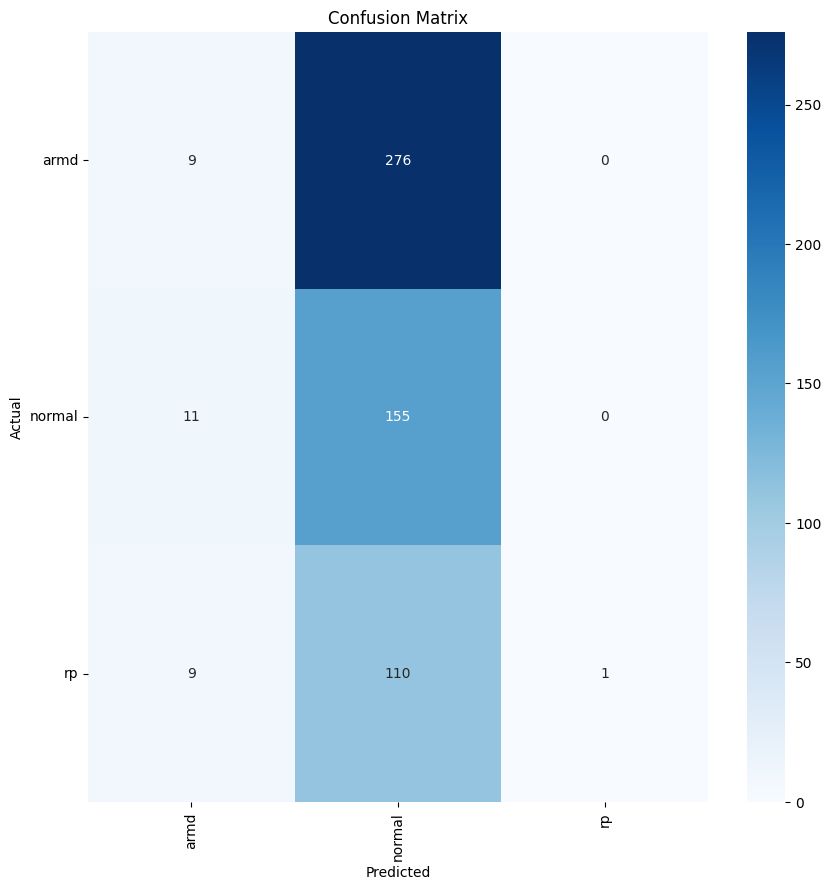

{'armd': 0, 'normal': 1, 'rp': 2}


In [80]:


# Generate a confusion matrix
cm = confusion_matrix(actuals, predictions)

# Get class names
class_names = list(train_set.class_to_idx.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set class names as labels
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'RETFound_MAE/{time.strftime("%Y%m%d_%H%M")}_RETFound_cfp_fine_tuned_ep1_confusion_matrix.png')
plt.show()
print(train_set.class_to_idx)